In [1]:
!pip install geopandas==1.0.0a1

  Using cached geopandas-1.0.0a1-py3-none-any.whl.metadata (2.2 kB)
Using cached geopandas-1.0.0a1-py3-none-any.whl (293 kB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.14.4
    Uninstalling geopandas-0.14.4:
      Successfully uninstalled geopandas-0.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mapreader 1.3.2 requires geopandas<1.0.0, but you have geopandas 1.0.0a1 which is incompatible.


In [2]:
import numpy as np
import geopandas as geopd
import pandas as pd

from pyproj import CRS

import matplotlib.pyplot as plt
from shapely import Polygon, wkt

import contextily as cx

from ast import literal_eval

import re

In [3]:
def load_dataframe(file_path: str):
    # read file
    df = pd.read_csv(file_path, index_col=0)

    # eval columns
    for col in df.columns:
        try:
            df[col] = df[col].apply(literal_eval)
        except:
            pass

    # read polygon
    if "polygon" in df.columns:
        df["polygon"] = df["polygon"].apply(
            lambda x: x if isinstance(x, Polygon) else wkt.loads(x)
        )
    else:
        df["polygon"] = df["coordinates"].apply(
            lambda x: Polygon.from_bounds(*x)
        )

    # convert to geo dataframe
    df = geopd.GeoDataFrame(df, geometry="polygon", crs="EPSG:4326")

    return df

# Load patch outputs

First we need to load in our data for plotting.

You should download the following files from [here](https://drive.google.com/drive/folders/14tSvFbH2DJSnuRX1B9dA7Ic9JhzVPmc1).

In [4]:
metadata = load_dataframe("./maps/metadata.csv")
patch_predictions = load_dataframe("./infer_railspace_predictions_patch_df.csv")

In [5]:
metadata.rename(columns={"name": "image_id"}, inplace=True)
metadata.set_index("image_id", inplace=True)

In [6]:
metadata.head()

url  \
image_id                                              
map_75650661.png  https://maps.nls.uk/view/75650661   
map_75650697.png  https://maps.nls.uk/view/75650697   
map_75650823.png  https://maps.nls.uk/view/75650823   
map_75650907.png  https://maps.nls.uk/view/75650907   
map_75650892.png  https://maps.nls.uk/view/75650892   

                                                        coordinates  \
image_id                                                              
map_75650661.png  (-4.2572021484375, 55.83677120280159, -4.17480...   
map_75650697.png  (-4.17755126953125, 55.83677120280159, -4.0979...   
map_75650823.png  (-4.25445556640625, 55.807455510806804, -4.174...   
map_75650907.png  (-4.17755126953125, 55.80899899270488, -4.0979...   
map_75650892.png  (-4.25445556640625, 55.77966236981707, -4.1748...   

                        crs  published_date  \
image_id                                      
map_75650661.png  EPSG:4326            1897   
map_75650697.png  EPSG:4326            1899   
map_75650823.png  EPSG:4326            1898   
map_75650907.png  EPSG:4326            1899   
map_75650892.png  EPSG:4326            1898   

                                                  grid_bb country  \
image_id                                                            
map_75650661.png  [(17, 63986, 40901)x(17, 64015, 40920)]     SCO   
map_75650697.png  [(17, 64015, 40901)x(17, 64043, 40920)]     SCO   
map_75650823.png  [(17, 63987, 40920)x(17, 64015, 40939)]     SCO   
map_75650907.png  [(17, 64015, 40920)x(17, 64043, 40938)]     SCO   
map_75650892.png  [(17, 63987, 40938)x(17, 64015, 40957)]     SCO   

                       county  \
image_id                        
map_75650661.png  Lanarkshire   
map_75650697.png  Lanarkshire   
map_75650823.png  Lanarkshire   
map_75650907.png  Lanarkshire   
map_75650892.png  Lanarkshire   

                                                            polygon  
image_id                                                             
map_75650661.png  POLYGON ((-4.2572 55.83677, -4.2572 55.86761, ...  
map_75650697.png  POLYGON ((-4.17755 55.83677, -4.17755 55.86761...  
map_75650823.png  POLYGON ((-4.25446 55.80746, -4.25446 55.83831...  
map_75650907.png  POLYGON ((-4.17755 55.809, -4.17755 55.83831, ...  
map_75650892.png  POLYGON ((-4.25446 55.77966, -4.25446 55.81054...

Since we mostly care about patches which **have** been classified as railspace, we will filter out predictions dataframe for only patches with predicted label equal to "railspace".

In [7]:
railspace_predictions = patch_predictions[patch_predictions["predicted_label"] == "railspace"].copy()

In [8]:
railspace_predictions.head()

parent_id  \
image_id                                                             
patch-6556-3725-6705-3874-#map_75650892.png#.png  map_75650892.png   
patch-447-745-596-894-#map_75650931.png#.png      map_75650931.png   
patch-1639-5066-1788-5120-#map_75650931.png#.png  map_75650931.png   
patch-1788-4917-1937-5066-#map_75650931.png#.png  map_75650931.png   
patch-1788-5066-1937-5120-#map_75650931.png#.png  map_75650931.png   

                                                                                         image_path  \
image_id                                                                                              
patch-6556-3725-6705-3874-#map_75650892.png#.png  /Users/rwood/LwM/mapreader/MapReader/worked_ex...   
patch-447-745-596-894-#map_75650931.png#.png      /Users/rwood/LwM/mapreader/MapReader/worked_ex...   
patch-1639-5066-1788-5120-#map_75650931.png#.png  /Users/rwood/LwM/mapreader/MapReader/worked_ex...   
patch-1788-4917-1937-5066-#map_75650931.png#.png  /Users/rwood/LwM/mapreader/MapReader/worked_ex...   
patch-1788-5066-1937-5120-#map_75650931.png#.png  /Users/rwood/LwM/mapreader/MapReader/worked_ex...   

                                                          shape  \
image_id                                                          
patch-6556-3725-6705-3874-#map_75650892.png#.png  (149, 149, 4)   
patch-447-745-596-894-#map_75650931.png#.png      (149, 149, 4)   
patch-1639-5066-1788-5120-#map_75650931.png#.png  (149, 149, 4)   
patch-1788-4917-1937-5066-#map_75650931.png#.png  (149, 149, 4)   
patch-1788-5066-1937-5120-#map_75650931.png#.png  (149, 149, 4)   

                                                              pixel_bounds  \
image_id                                                                     
patch-6556-3725-6705-3874-#map_75650892.png#.png  (6556, 3725, 6705, 3874)   
patch-447-745-596-894-#map_75650931.png#.png          (447, 745, 596, 894)   
patch-1639-5066-1788-5120-#map_75650931.png#.png  (1639, 5066, 1788, 5120)   
patch-1788-4917-1937-5066-#map_75650931.png#.png  (1788, 4917, 1937, 5066)   
patch-1788-5066-1937-5120-#map_75650931.png#.png  (1788, 5066, 1937, 5120)   

                                                                                        coordinates  \
image_id                                                                                              
patch-6556-3725-6705-3874-#map_75650892.png#.png  (-4.184117317199707, 55.787177317923906, -4.18...   
patch-447-745-596-894-#map_75650931.png#.png      (-4.172755479812622, 55.80515046829179, -4.171...   
patch-1639-5066-1788-5120-#map_75650931.png#.png  (-4.159966707229614, 55.77966236981707, -4.158...   
patch-1788-4917-1937-5066-#map_75650931.png#.png  (-4.158368110656738, 55.779988057776755, -4.15...   
patch-1788-5066-1937-5120-#map_75650931.png#.png  (-4.158368110656738, 55.77966236981707, -4.156...   

                                                        crs  \
image_id                                                      
patch-6556-3725-6705-3874-#map_75650892.png#.png  EPSG:4326   
patch-447-745-596-894-#map_75650931.png#.png      EPSG:4326   
patch-1639-5066-1788-5120-#map_75650931.png#.png  EPSG:4326   
patch-1788-4917-1937-5066-#map_75650931.png#.png  EPSG:4326   
patch-1788-5066-1937-5120-#map_75650931.png#.png  EPSG:4326   

                                                                                            polygon  \
image_id                                                                                              
patch-6556-3725-6705-3874-#map_75650892.png#.png  POLYGON ((-4.18252 55.78718, -4.18252 55.78808...   
patch-447-745-596-894-#map_75650931.png#.png      POLYGON ((-4.17116 55.80515, -4.17116 55.80605...   
patch-1639-5066-1788-5120-#map_75650931.png#.png  POLYGON ((-4.15837 55.77966, -4.15837 55.77999...   
patch-1788-4917-1937-5066-#map_75650931.png#.png  POLYGON ((-4.15677 55.77999, -4.15677 55.78089...   
patch-1788-5066-1937-5120-#map_75650931.png#.

# Plotting values (e.g. confidence)

We can plot any value in our geodataframe using the `.plot()` function.
For example, the below shows how to plot confidence scores for each of our patches.

In [9]:
# convert to web mercator for plotting
metadata_wm = metadata.to_crs(epsg=3857)
railspace_predictions_wm = railspace_predictions.to_crs(epsg=3857)

## All parent maps

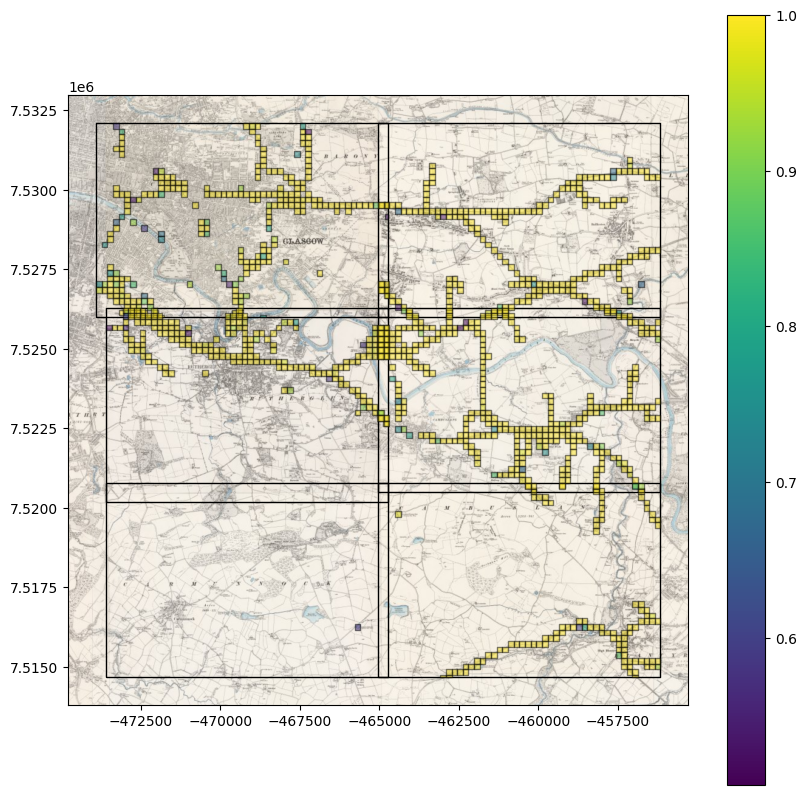

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

metadata_wm.plot(color="none", edgecolor="k", ax=ax)
railspace_predictions_wm.plot("conf", edgecolor="k", ax=ax, legend=True, alpha=0.5)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

## One parent map

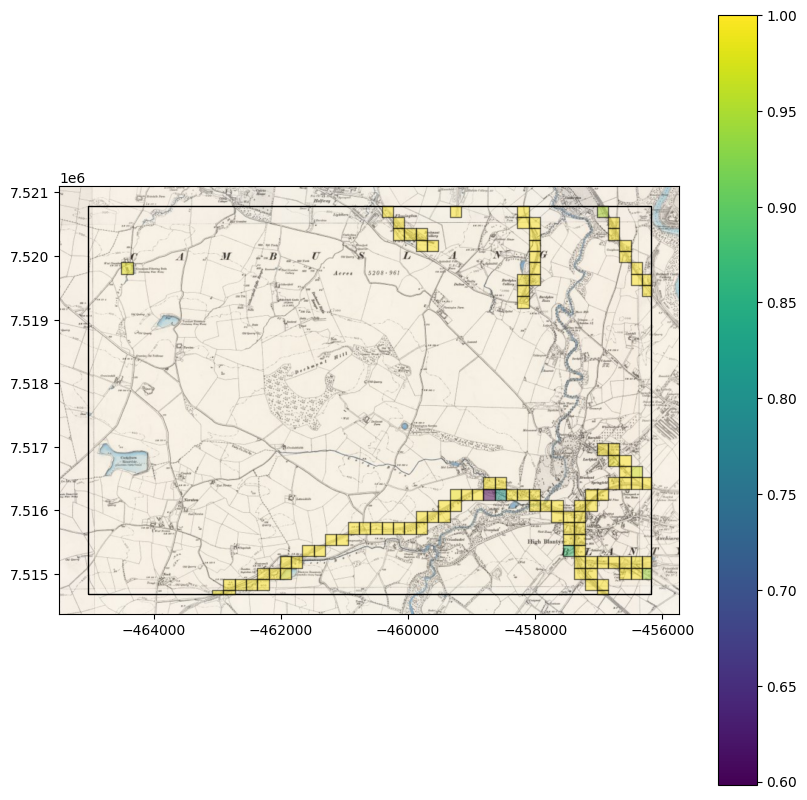

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

metadata_wm[metadata_wm.index=="map_75650931.png"].plot(color="none", edgecolor="k", ax=ax)
railspace_predictions_wm[railspace_predictions_wm["parent_id"]=="map_75650931.png"].plot("conf", edgecolor="k", ax=ax, legend=True, alpha=0.5)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

## Coverage

It might also be useful to quantify how much coverage railspace patches in the area you've looked at.

This can be done by calculating the total area of the railspace patches and of the six parent maps, then using this to find a percentage coverage.

In [12]:
geod = CRS("EPSG:4326").get_geod() # create Geod for area/distance calculations

In [14]:
railspace_poly = railspace_predictions["polygon"].union_all()
total_poly = metadata["polygon"].union_all()

In [15]:
railspace_area, _ = geod.geometry_area_perimeter(railspace_poly)
total_area, _ = geod.geometry_area_perimeter(total_poly)

In [16]:
print(f"Railspace exists on {abs(railspace_area):.0f} m^2 of patches")
print(f"Railspace patches covers {abs(railspace_area / total_area):.2%} of the total area")

Railspace exists on 10077571 m^2 of patches
Railspace patches covers 10.42% of the total area


## Clustering

The below calculates the distance between railspace patches.

From this we can find the average distance between railspace patches and also plot a histogram showing how distances between railspace patches change.

In [17]:
geod = CRS("EPSG:4326").get_geod() # create Geod for area/distance calculations

In [18]:
# convert to british national grid and calculate center of patch
railspace_predictions_27700 = railspace_predictions.to_crs(epsg=27700)
railspace_predictions_27700["centroid"]  = railspace_predictions_27700["polygon"].apply(lambda x: x.centroid)
railspace_predictions_27700.set_geometry("centroid", inplace=True)

# get indices of patches within 1000m of each other
indices = railspace_predictions_27700.sindex.query(railspace_predictions_27700.geometry, predicate="dwithin", distance=1000).T

# remove duplicates (i.e. [1, 2] and [2, 1])
indices.sort(axis=1)
indices = np.unique(indices, axis=0)

We've now found indices of pairs of patches which are within 1km of eachother.

We can use these to calculate the exact distance between the pairs and log these distances in our dataframe.

In [22]:
indices

array([[   0,    0],
       [   1,    1],
       [   2,    2],
       ...,
       [1067, 1067],
       [1067, 1068],
       [1068, 1068]])

In [23]:
# create an empty pandas series to store distances
distances_series = pd.Series(index=railspace_predictions.index)
distances_series = distances_series.apply(lambda x: [])

# loop through pairs of indices and calculate distance
for index in indices:
    patch_1 = railspace_predictions.iloc[index[0]]
    patch_2 = railspace_predictions.iloc[index[1]]

    if not patch_1.equals(patch_2):
        lon_1, lat_1 = patch_1["polygon"].centroid.x, patch_1["polygon"].centroid.y
        lon_2, lat_2 = patch_2["polygon"].centroid.x, patch_2["polygon"].centroid.y
        
        _, _, dist = geod.inv(lon_1, lat_1, lon_2, lat_2)
        
        # append distance to both patches (as it is a two-way relationship)
        distances_series.loc[patch_1.name].append(abs(dist))
        distances_series.loc[patch_2.name].append(abs(dist))

# calculate average distance and bins (for histogram)
railspace_predictions["avg dist"] = distances_series.apply(lambda x: np.mean(x) if len(x) > 0 else np.NaN)
railspace_predictions["bins"] = distances_series.apply(lambda x: np.histogram(x, bins=10, range=(0,1000))[0] if len(x) > 0 else np.NaN)

## All parent maps

We can now plot the average distance between railspace patches (only considering those within 1km of eachother) on our maps.

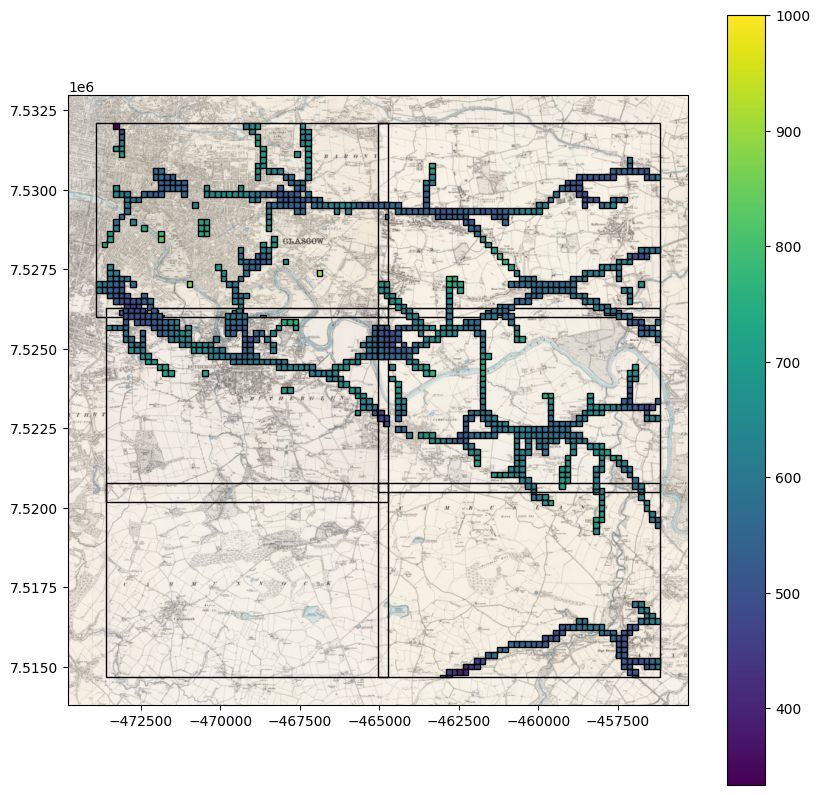

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

# convert to web mercator for plotting
railspace_predictions_wm = railspace_predictions.to_crs(epsg=3857)

metadata_wm.plot(color="none", edgecolor="k", ax=ax)
railspace_predictions_wm.plot("avg dist", ax=ax, legend=True, edgecolor="k", vmax=1000)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

## One parent map

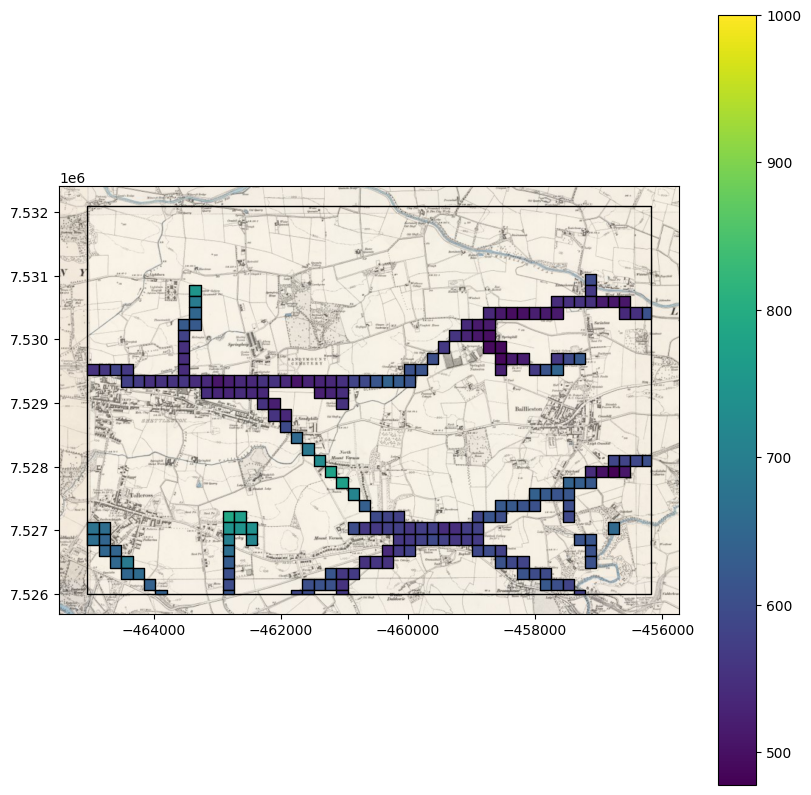

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

metadata_wm[metadata_wm.index=="map_75650697.png"].plot(color="none", edgecolor="k", ax=ax)
railspace_predictions_wm[railspace_predictions_wm["parent_id"]=="map_75650697.png"].plot("avg dist", ax=ax, legend=True, edgecolor="k", vmax=1000)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

Or, alternatively, we can view this as a histogram.

In [30]:
hist_df = railspace_predictions.dropna(subset=["bins"]).copy()
bins_c = np.linspace(50, 950, 10)

hist_df[[*bins_c]] = [*hist_df["bins"]]

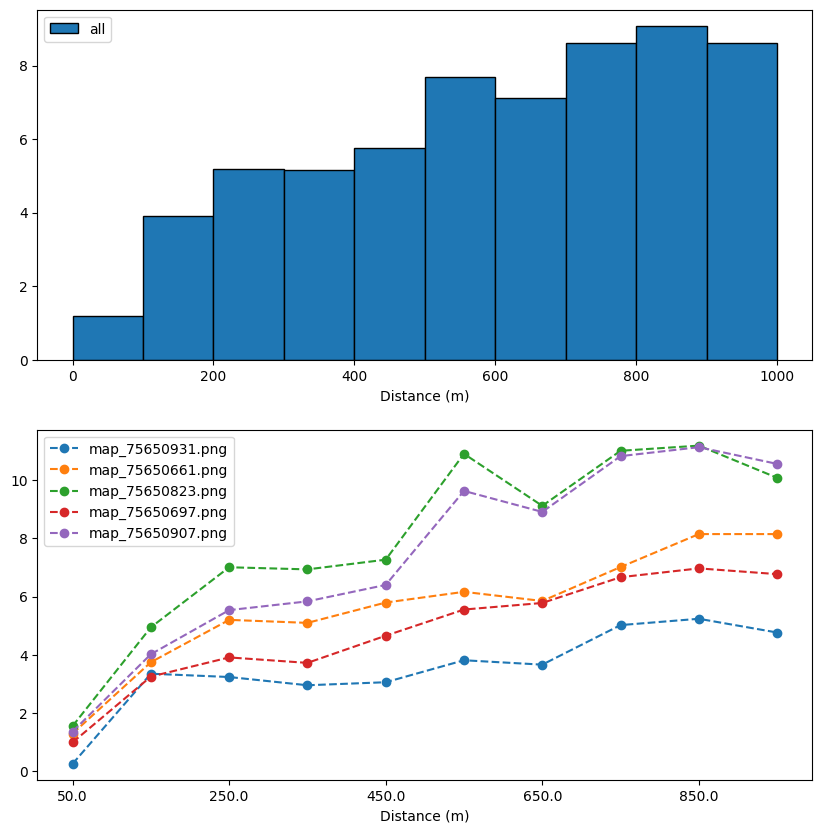

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

all = hist_df[[*bins_c]].aggregate("mean")
axs[0].bar(all.index-50, all.values, width=100, align="edge", label="all", edgecolor="k")

for parent_id in hist_df["parent_id"].unique():
    hist_df[hist_df["parent_id"]==parent_id][[*bins_c]].aggregate("mean").plot(ax=axs[1], label=parent_id, marker="o", linestyle="--")

for ax in axs:
    ax.legend(loc="upper left")
    ax.set_xlabel("Distance (m)")

Since we are only looking at distances for patches within 1km of eachother, we can also see how many patches are further than 1km from eachother by counting the `NaN` values in our dataframe.

This indicates patches which are completely isolated.

In [39]:
isolated_patches = len(railspace_predictions[railspace_predictions["avg dist"].isna()])

In [40]:
connected_patches = len(railspace_predictions[railspace_predictions["avg dist"].notna()])

In [42]:
print(f"No. of isolated patches: {isolated_patches}")
print(f"No. of connected patches: {connected_patches}")
print(f"Percentage of isolated patches: {isolated_patches/connected_patches:0.2%}")


No. of isolated patches: 2
No. of connected patches: 1067
Percentage of isolated patches: 0.19%


### Clustering at the parent level

In [69]:
for id, count in railspace_predictions.aggregate("parent_id").value_counts().iteritems():
    metadata.loc[id, "count"] = count

/var/folders/fn/j7v8jkl1717c1b6sy_sr0szc0000gr/T/ipykernel_13776/3928097677.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, count in railspace_predictions.aggregate("parent_id").value_counts().iteritems():


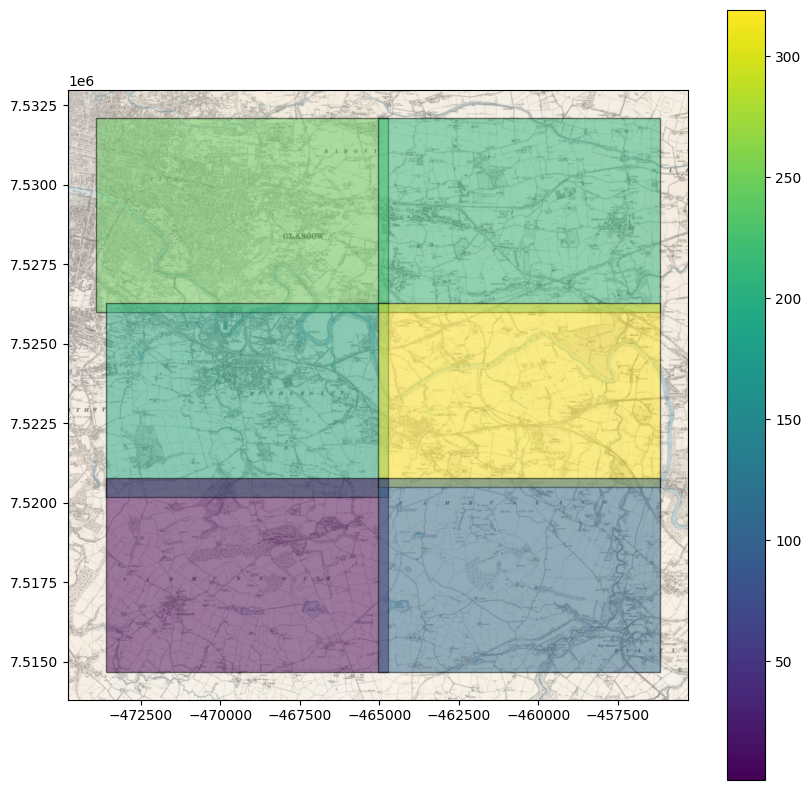

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

metadata_wm = metadata.to_crs(epsg=3857)
metadata_wm.plot("count", ax=ax, legend=True, alpha=0.5, edgecolor="k")
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

# Load text outputs

We can also load the text data to find patterns in the text on maps, much as we did for the newspaper data.

In [71]:
text_df = load_dataframe("./deepsolo_outputs.csv")

In [72]:
text_df.dropna(subset=["text"], inplace=True)

In [73]:
text_df.head()

image_id                                            polygon  \
0  map_75650697.png  POLYGON ((-4.15301 55.8543, -4.15297 55.8543, ...   
1  map_75650697.png  POLYGON ((-4.15303 55.85153, -4.15298 55.85152...   
2  map_75650697.png  POLYGON ((-4.15025 55.85435, -4.15021 55.85436...   
3  map_75650697.png  POLYGON ((-4.15137 55.8518, -4.15135 55.8518, ...   
4  map_75650697.png  POLYGON ((-4.15605 55.85401, -4.156 55.85401, ...   

         crs     text  score  
0  EPSG:4326  TERRACE   0.82  
1  EPSG:4326   QUARRY   0.74  
2  EPSG:4326    LODGE   0.81  
3  EPSG:4326       SP   0.44  
4  EPSG:4326  UNCTION   0.61

## Find text

We need to define a query to look for.

In the below example, we use "rail.*" to our to look for words like railway.

In [74]:
# define the regular expression
regex = r"\b(rail.*?)\b"
# compile the regex use an ignore case flag
# i.e. we will ignore uppercase
pattern = re.compile(regex, re.I)

In [75]:
pattern.findall("a railway station")

['railway']

In [76]:
text_df["hits"] = text_df['text'].apply(lambda x: bool(pattern.findall(x)))

In [77]:
hits = text_df[text_df["hits"]]
hits.head()

image_id                                            polygon  \
41   map_75650697.png  POLYGON ((-4.10762 55.84223, -4.10759 55.84221...   
355  map_75650697.png  POLYGON ((-4.13644 55.84258, -4.13638 55.84257...   
506  map_75650697.png  POLYGON ((-4.15739 55.8397, -4.15738 55.83967,...   
520  map_75650697.png  POLYGON ((-4.11589 55.8555, -4.11582 55.85548,...   
680  map_75650823.png  POLYGON ((-4.20604 55.835, -4.20602 55.83503, ...   

           crs     text  score  hits  
41   EPSG:4326  RAILWAY   0.68  True  
355  EPSG:4326  RAILWAY   0.44  True  
506  EPSG:4326  RAILWAY   0.73  True  
520  EPSG:4326  RAILWAY   0.54  True  
680  EPSG:4326  RAILWAY   0.75  True

## All parents

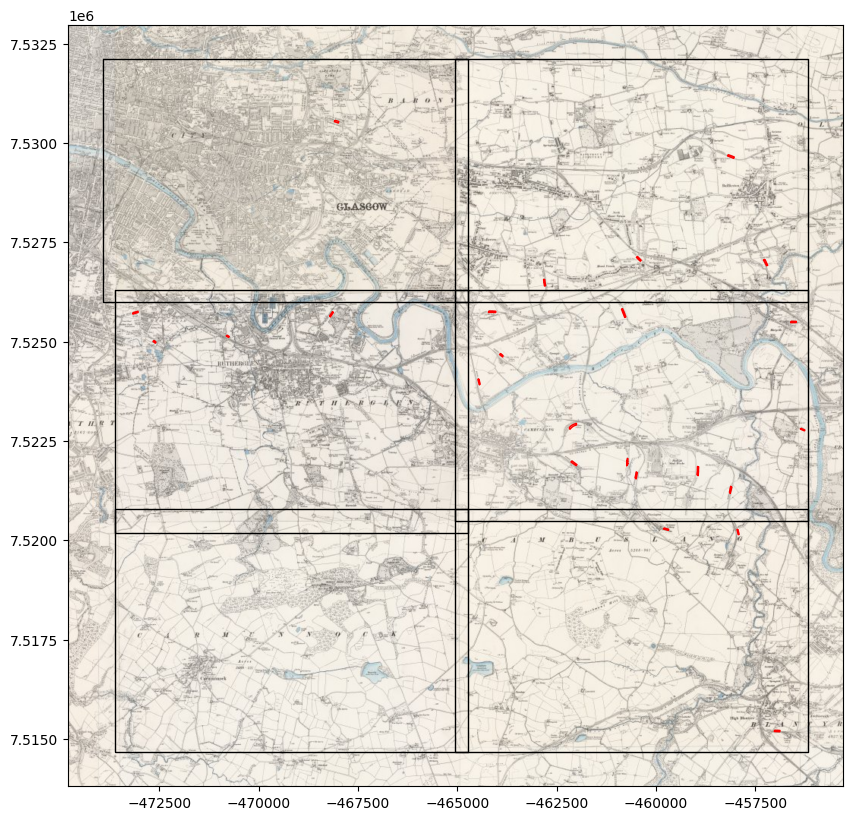

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))

# convert to web mercator for plotting
hits_wm = hits.to_crs(epsg=3857)

metadata_wm.plot(ax=ax, legend=True, edgecolor="black", color="none")
hits_wm.plot(color="none", edgecolor="red", ax=ax)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

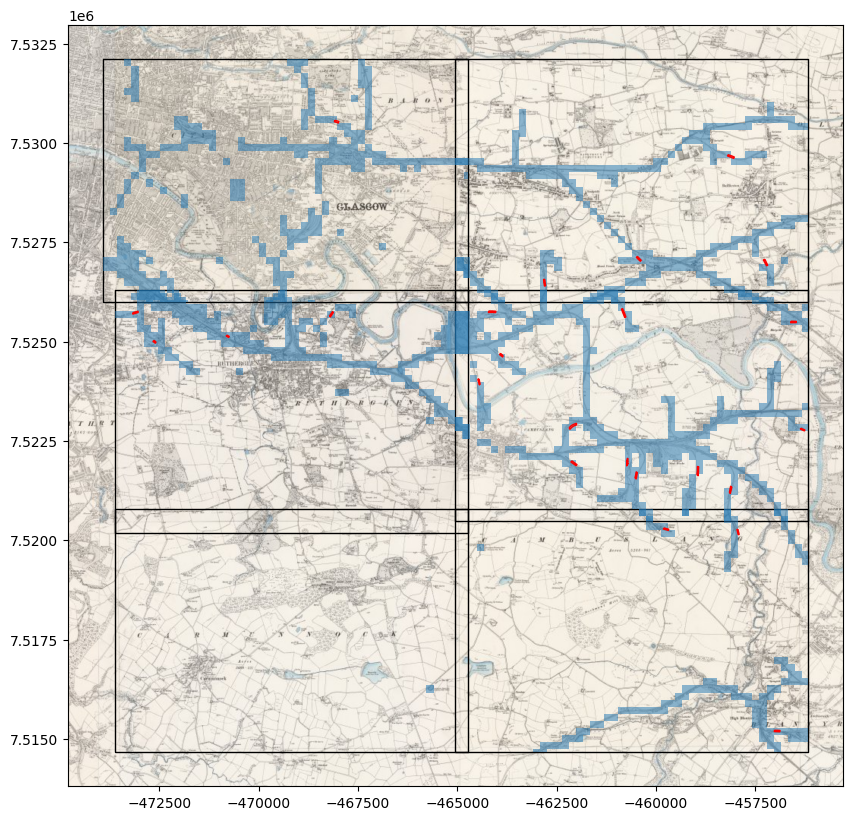

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))

# convert to web mercator for plotting
hits_wm = hits.to_crs(epsg=3857)

metadata_wm.plot(ax=ax, legend=True, edgecolor="black", color="none")
railspace_predictions_wm.plot(ax=ax, legend=True, alpha=0.5)
hits_wm.plot(color="none", edgecolor="red", ax=ax)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

## One parent

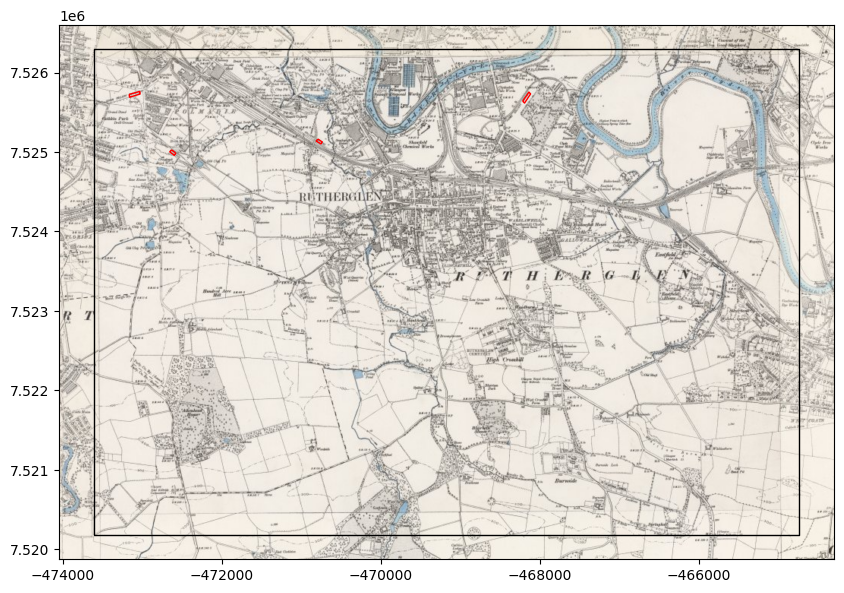

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

metadata_wm[metadata_wm.index=="map_75650823.png"].plot(color="none", edgecolor="k", ax=ax)
hits_wm[hits_wm["image_id"] == "map_75650823.png"].plot(color="none", edgecolor="red", ax=ax)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")

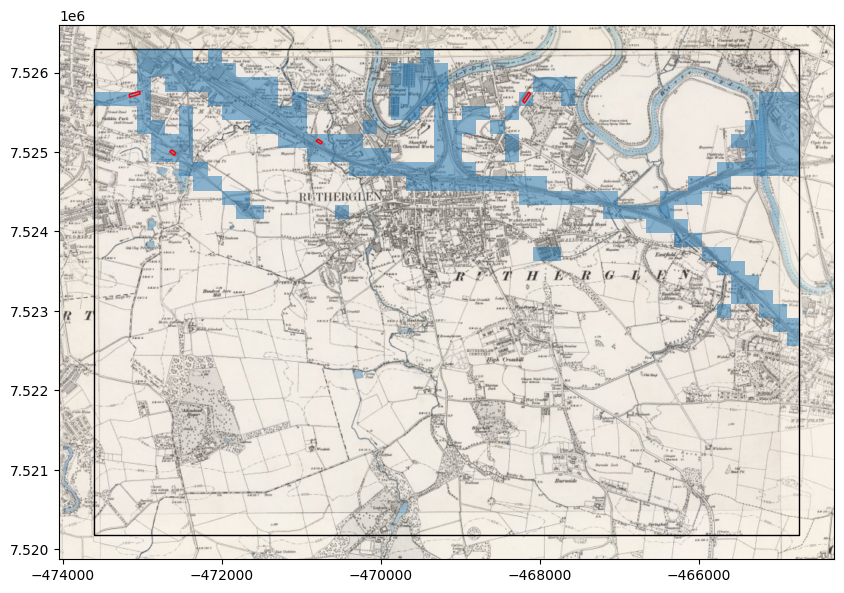

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))

metadata_wm[metadata_wm.index=="map_75650823.png"].plot(color="none", edgecolor="k", ax=ax)
railspace_predictions_wm[railspace_predictions_wm["parent_id"]=="map_75650823.png"].plot(ax=ax, legend=True, alpha=0.5)
hits_wm[hits_wm["image_id"] == "map_75650823.png"].plot(color="none", edgecolor="red", ax=ax)
cx.add_basemap(ax=ax, crs=3857, source="https://api.maptiler.com/tiles/uk-osgb10k1888/{z}/{x}/{y}.jpg?key=uZV86JxJQOHqWjz4QFan")